In [13]:
# =================================================================================
# SECTION 1: PROJECT SCAFFOLDING & CONFIGURATION
# =================================================================================

# ---------------------------------------------------------------------------------
# 1.1: IMPORTS
# All necessary libraries for the project.
# ---------------------------------------------------------------------------------
%matplotlib inline 
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTConfig
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold # We might use this later for robustness
from collections import defaultdict
import copy

# Set a seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [14]:

# ---------------------------------------------------------------------------------
# 1.2: CONFIGURATION CLASS
# This class holds all hyperparameters and settings in one place.
# ---------------------------------------------------------------------------------
class Config:
    # --- Data Paths and Domains ---
    DATA_DIR = r"D:\Haseeb\Datasets\VLCS" # Make sure this path is correct for your dataset
    DOMAINS = ["Caltech101", "LabelMe", "SUN09", "VOC2007"]
    
    # --- Model & Architecture ---
    MODEL_NAME = "WinKawaks/vit-tiny-patch16-224"
    NUM_CLASSES = 5
    ### CHANGE ###
    NUM_HEADS = 4
    DROPOUT_OPTIONS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
    
    # --- Training Hyperparameters ---
    BATCH_SIZE = 128
    NUM_EPOCHS = 5
    LEARNING_RATE = 1e-4
    OPTIMIZER = "AdamW"
    
    # --- Hardware & Reproducibility ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 42

# Instantiate the config
config = Config()

# Print out the configuration to verify
print("--- Project Configuration ---")
for key, value in config.__class__.__dict__.items():
    if not key.startswith('__'):
        print(f"{key}: {value}")
print("---------------------------")
print(f"Device: {config.DEVICE}")

# ---------------------------------------------------------------------------------
# 1.3: RESULTS TRACKER
# A list to store the final results from each LODO experiment run.
# This will be converted to a DataFrame at the end for analysis.
# ---------------------------------------------------------------------------------
experiment_results = []

print("\nProject scaffolding is complete. Ready for Section 2: Data Loading.")

--- Project Configuration ---
DATA_DIR: D:\Haseeb\Datasets\VLCS
DOMAINS: ['Caltech101', 'LabelMe', 'SUN09', 'VOC2007']
MODEL_NAME: WinKawaks/vit-tiny-patch16-224
NUM_CLASSES: 5
NUM_HEADS: 4
DROPOUT_OPTIONS: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
BATCH_SIZE: 128
NUM_EPOCHS: 5
LEARNING_RATE: 0.0001
OPTIMIZER: AdamW
DEVICE: cuda
SEED: 42
---------------------------
Device: cuda

Project scaffolding is complete. Ready for Section 2: Data Loading.


In [15]:
# =================================================================================
# SECTION 2: DATA LOADING & PREPROCESSING
# =================================================================================

# ---------------------------------------------------------------------------------
# 2.1: IMAGE TRANSFORMATIONS
# Define the transformations for training (with augmentation) and validation/testing.
# ---------------------------------------------------------------------------------

# The ViT model was pre-trained on images of size 224x224
IMG_SIZE = 224

# The normalization values are standard for many pre-trained models
# but it's good practice to use the ones specified by the model's authors if available.
# For ViT, a simple (0.5, 0.5, 0.5) normalization is common.
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(), # A simple data augmentation technique
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
}


In [16]:
# ---------------------------------------------------------------------------------
# 2.2: CUSTOM PACS DATASET CLASS
# This class will read the images and labels from our specific folder structure.
# ---------------------------------------------------------------------------------
import random # Make sure to import the 'random' library at the top of the cell.

class VLCSDataset(Dataset):
    def __init__(self, root_dir, domains, transform=None):
        self.root_dir = root_dir
        self.domains = domains
        self.transform = transform
        self.image_paths = []
        self.labels = []
        ### CHANGE 2: Add a counter for corrupted images ###
        self.corrupted_images_count = 0
        
        try:
            self.classes = sorted(os.listdir(os.path.join(root_dir, domains[0])))
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        except FileNotFoundError:
            print(f"Error: Could not find domain folder at {os.path.join(root_dir, domains[0])}")
            print("Please ensure your DATA_DIR and DOMAINS in the Config class are correct.")
            raise

        for domain in self.domains:
            domain_path = os.path.join(self.root_dir, domain)
            for class_name in self.classes:
                class_path = os.path.join(domain_path, class_name)
                if os.path.isdir(class_path):
                    for img_name in os.listdir(class_path):
                        self.image_paths.append(os.path.join(class_path, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
        except (OSError, IOError) as e:
            ### CHANGE 3: Increment the counter and replace with a random image ###
            self.corrupted_images_count += 1
            # You can uncomment the print statement below for verbose debugging if you want
            # print(f"Warning: Corrupted image at {img_path}. Replacing with random. Total corrupt: {self.corrupted_images_count}")
            
            # Pick a new random index
            new_idx = random.randint(0, len(self) - 1)
            # Recursively call __getitem__ with the new index.
            return self.__getitem__(new_idx)

        # The transformation part remains the same
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [17]:
# =================================================================================
# SECTION 2.3: DATALOADER HELPER FUNCTION (NEW 80/20 SPLIT VERSION)
# =================================================================================
# Replace the old get_dataloaders function in Section 2 of BOTH notebooks with this.

from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

def get_dataloaders(root_dir, target_domain, all_domains, batch_size, seed):
    """
    Creates dataloaders for a LODO split using an 80/20 split on the source domains.
    """
    source_domains = [d for d in all_domains if d != target_domain]
    
    print(f"--- Creating DataLoaders (80/20 Split Strategy) ---")
    print(f"Target (Test) Domain: {target_domain}")
    print(f"Source Domains for Train/Val: {source_domains}")
    
    # 1. Create a single, large dataset by combining all source domains
    source_dataset = VLCSDataset(
        root_dir=root_dir, 
        domains=source_domains, 
        transform=data_transforms['train'] # Use training transforms for the whole source
    )
    
    # We need to perform a stratified split to ensure the train and val sets
    # have a similar distribution of classes.
    indices = list(range(len(source_dataset)))
    labels = source_dataset.labels
    
    # Use sklearn's train_test_split to get indices for an 80% train / 20% val split
    train_idx, val_idx = train_test_split(
        indices, 
        test_size=0.2, 
        stratify=labels, 
        random_state=seed
    )
    
    # 2. Create the training and validation subsets
    train_subset = Subset(source_dataset, train_idx)
    val_subset = Subset(source_dataset, val_idx)
    
    # Important: The validation subset should not use training augmentations (like RandomFlip).
    # We create a new dataset object for validation with the correct transforms.
    # This is a cleaner way to handle transforms for subsets.
    val_dataset_clean = VLCSDataset(root_dir=root_dir, domains=source_domains, transform=data_transforms['val'])
    val_subset_final = Subset(val_dataset_clean, val_idx)
    
    # 3. Create the test dataset from the full target domain
    test_dataset = VLCSDataset(
        root_dir=root_dir, 
        domains=[target_domain], 
        transform=data_transforms['val']
    )

    # 4. Create the DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset_final, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    print(f"Source data size: {len(source_dataset)}")
    print(f"  -> Training on: {len(train_subset)} images (80%)")
    print(f"  -> Validating on: {len(val_subset_final)} images (20%)")
    print(f"Testing on full '{target_domain}' domain: {len(test_dataset)} images")
    print("----------------------------------------------------")
    
    return train_loader, val_loader, test_loader

In [18]:
# =================================================================================
# SECTION 3: THE MODEL ARCHITECTURE
# =================================================================================

# ---------------------------------------------------------------------------------
# 3.1: CUSTOM ViT MODEL WITH EVOLUTIONARY HEADS
# We define a class that wraps the ViT backbone and adds our 4 competing heads.
# ---------------------------------------------------------------------------------

class EvolutionaryViT(nn.Module):
    def __init__(self, model_name, num_classes, dropout_rates: list):
        """
        Args:
            model_name (string): The name of the pre-trained ViT model from Hugging Face.
            num_classes (int): The number of output classes.
            num_heads (int): The number of parallel classification heads.
            dropout_rate (float): The dropout probability.
        """
        super(EvolutionaryViT, self).__init__()
        
        # 1. Load the pre-trained ViT backbone
        # We use ViTModel, which gives us the feature extractor without the final classification layer.
        self.vit_backbone = ViTModel.from_pretrained(model_name)
        
        # Get the hidden size (feature dimension) from the model's config
        hidden_dim = self.vit_backbone.config.hidden_size
        
        # 2. Create the list of competing heads
        # We use nn.ModuleList, which is the proper way to hold a list of PyTorch modules.
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Dropout(p=rate), # Use the specific rate for this head
                nn.Linear(hidden_dim, num_classes)
            ) for rate in dropout_rates
        ])

    def update_dropout_rates(self, new_rates: list):
        """
        Updates the dropout probability for each head.
        This allows us to change the rates between epochs without re-creating the model.
        """
        for i, head in enumerate(self.heads):
            # nn.Sequential has layers indexed. 0 is Dropout, 1 is Linear.
            head[0].p = new_rates[i]
        
    def forward(self, images):
        """
        Defines the forward pass of the model.
        """
        # 1. Get features from the backbone
        # The output is a dictionary-like object. We want the 'last_hidden_state'.
        outputs = self.vit_backbone(pixel_values=images)
        
        # For ViT, the feature representation for the entire image is the output
        # corresponding to the special [CLS] token, which is the first one.
        # Shape: (batch_size, sequence_length, hidden_dim) -> (batch_size, hidden_dim)
        feature_vector_z = outputs.last_hidden_state[:, 0, :]
        
        # 2. Pass the feature vector through all heads
        head_outputs = {}
        for i, head in enumerate(self.heads):
            head_outputs[f'head_{i+1}'] = head(feature_vector_z)
            
        return head_outputs

# --- Let's test it to make sure it works ---
print("\nModel architecture seems correct. Ready for Section 4: Training and Evaluation Logic.")


Model architecture seems correct. Ready for Section 4: Training and Evaluation Logic.


In [19]:
# =================================================================================
# SECTION 4: TRAINING & EVALUATION LOGIC
# =================================================================================

# =================================================================================
# SECTION 4.1: TRAIN_ONE_EPOCH FUNCTION (FINAL "TRAIN ALL" STRATEGY)
# =================================================================================
# Replace your old train_one_epoch function with this new, correct version.

def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_winner_loss = 0.0
    head_correct_preds = defaultdict(int)
    total_samples = 0
    progress_bar = tqdm(train_loader, desc="Training Epoch", leave=False)

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        # --- Step 1: Main Forward Pass ---
        # We get the feature vector z WITH the graph attached
        z = model.vit_backbone(pixel_values=images).last_hidden_state[:, 0, :]
        
        # --- Step 2: Create a Detached Copy of z ---
        # This z_detached has the same values but no gradient history linking it to the backbone.
        z_detached = z.detach()

        # --- Step 3: Calculate All Losses and Find the Winner ---
        head_outputs = {}
        all_losses = {}
        batch_accuracies = {}

        for i, head in enumerate(model.heads):
            head_name = f'head_{i+1}'
            
            # Use the "live" z for the winner's path, detached z for losers' path
            # We calculate both for now and decide which one to use for backprop later
            live_logits = head(z)
            detached_logits = head(z_detached)

            head_outputs[head_name] = live_logits # Store live logits for accuracy check
            
            # Store the two possible losses for each head
            all_losses[head_name] = {
                'live': criterion(live_logits, labels),
                'detached': criterion(detached_logits, labels)
            }

            # Find accuracy to determine the winner
            _, preds = torch.max(live_logits, 1)
            correct = torch.sum(preds == labels).item()
            batch_accuracies[head_name] = correct / labels.size(0)

        winner_head_name = max(batch_accuracies, key=batch_accuracies.get)

        # --- Step 4: Combine Losses for Backpropagation ---
        # Start with the winner's "live" loss, which will train the backbone.
        final_loss = all_losses[winner_head_name]['live']
        
        # Add the losers' "detached" losses, which will only train the heads.
        for head_name, loss_dict in all_losses.items():
            if head_name != winner_head_name:
                final_loss += loss_dict['detached']
        
        # --- Step 5: Single Backpropagation and Optimizer Step ---
        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()

        # --- Update logging stats ---
        total_winner_loss += all_losses[winner_head_name]['live'].item()
        for head_name, logits in head_outputs.items():
             _, preds = torch.max(logits, 1)
             head_correct_preds[head_name] += torch.sum(preds == labels).item()
        total_samples += labels.size(0)
    
    # --- End of Epoch ---
    final_head_accuracies = {name: (correct / total_samples) for name, correct in head_correct_preds.items()}
    return {
        "avg_winner_loss": total_winner_loss / len(train_loader),
        "head_accuracies": final_head_accuracies
    }

In [20]:
# =================================================================================
# SECTION 4: TRAINING & EVALUATION LOGIC (ADVANCED STRATEGY)
# =================================================================================


# ---------------------------------------------------------------------------------
# 4.2: EVALUATE FUNCTION
# (This function is correct and does not need to change)
# ---------------------------------------------------------------------------------
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_preds = 0
    total_samples = 0
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            total_samples += labels.size(0)
            head_outputs = model(images)
            all_logits = torch.stack(list(head_outputs.values()))
            ensembled_logits = torch.mean(all_logits, dim=0)
            loss = criterion(ensembled_logits, labels)
            total_loss += loss.item()
            _, preds = torch.max(ensembled_logits, 1)
            correct_preds += torch.sum(preds == labels).item()
    avg_loss = total_loss / len(data_loader)
    accuracy = correct_preds / total_samples
    return {
        "avg_loss": avg_loss,
        "accuracy": accuracy
    }

# --- Quick Test of the Functions (Optional but Recommended) ---
### CHANGE ###
# The test block is now updated to work with the new model __init__
# and the new 80/20 get_dataloaders function.
# ---------------------------------------------------------------------------------
print("Running a quick test of the training and evaluation functions...")

# We need some dataloaders for the test
target_domain_test = config.DOMAINS[3] # "sketch"
train_loader_test, val_loader_test, _ = get_dataloaders(
    root_dir=config.DATA_DIR,
    target_domain=target_domain_test,
    all_domains=config.DOMAINS,
    batch_size=config.BATCH_SIZE,
    seed=config.SEED # Pass the seed
)

# 1. Generate an initial list of dropout rates for the test
initial_dropout_rates = list(np.random.choice(
    config.DROPOUT_OPTIONS, 
    config.NUM_HEADS, 
    replace=False
))
print(f"Test model initial dropout rates: {initial_dropout_rates}")

# 2. Instantiate the model using the LIST of rates
test_model = EvolutionaryViT(
    model_name=config.MODEL_NAME,
    num_classes=config.NUM_CLASSES,
    dropout_rates=initial_dropout_rates # Pass the list here
).to(config.DEVICE)

test_optimizer = torch.optim.AdamW(test_model.parameters(), lr=config.LEARNING_RATE)
test_criterion = nn.CrossEntropyLoss()

# Run one training epoch
train_metrics = train_one_epoch(test_model, train_loader_test, test_optimizer, test_criterion, config.DEVICE)
print("\n--- One Training Epoch Test ---")
print(f"Average Winner Loss: {train_metrics['avg_winner_loss']:.4f}") 
print("Final Head Accuracies for the Epoch:")
for name, acc in train_metrics['head_accuracies'].items():
    print(f"  {name}: {acc:.4f}")

# Run one evaluation pass
eval_metrics = evaluate(test_model, val_loader_test, test_criterion, config.DEVICE)
print("\n--- One Evaluation Pass Test ---")
print(f"Ensembled Validation Loss: {eval_metrics['avg_loss']:.4f}")
print(f"Ensembled Validation Accuracy: {eval_metrics['accuracy']:.4f}")

print("\nTraining and evaluation logic seems correct. Ready for Section 5: The Main Experiment Loop.")

Running a quick test of the training and evaluation functions...
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: VOC2007
Source Domains for Train/Val: ['Caltech101', 'LabelMe', 'SUN09']
Source data size: 7353
  -> Training on: 5882 images (80%)
  -> Validating on: 1471 images (20%)
Testing on full 'VOC2007' domain: 3376 images
----------------------------------------------------
Test model initial dropout rates: [np.float64(0.1), np.float64(0.2), np.float64(0.6), np.float64(0.3)]


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]


--- One Training Epoch Test ---
Average Winner Loss: 7.8532
Final Head Accuracies for the Epoch:
  head_1: 0.1241
  head_2: 0.1802
  head_3: 0.6726
  head_4: 0.3699


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


--- One Evaluation Pass Test ---
Ensembled Validation Loss: 0.7628
Ensembled Validation Accuracy: 0.7437

Training and evaluation logic seems correct. Ready for Section 5: The Main Experiment Loop.


In [21]:
# =================================================================================
# SECTION 5: THE MAIN EXPERIMENT LOOP (ADVANCED STRATEGY)
# =================================================================================
# This version implements the "Winner-Stays, Losers-Re-roll" dropout strategy.
# The dropout rates are now dynamic and adapt based on epoch performance.
# ---------------------------------------------------------------------------------

# A fresh copy of the config to ensure we start clean
config = Config()

# Loop over each domain to set it as the target domain once
for target_domain in config.DOMAINS:
    print(f"==============================================================")
    print(f"  STARTING LODO EXPERIMENT: Target Domain = {target_domain.upper()}")
    print(f"==============================================================")
    
    # --- 1. Setup for this specific LODO run ---
    # Get the specific data loaders for this train/test split
    train_loader, val_loader, test_loader = get_dataloaders(
        root_dir=config.DATA_DIR,
        target_domain=target_domain,
        all_domains=config.DOMAINS,
        batch_size=config.BATCH_SIZE, seed=config.SEED
    )
    
    # Initialize the first set of random dropout rates for the competing heads.
    # np.random.choice ensures we get unique rates if possible.
    current_dropout_rates = list(np.random.choice(
        config.DROPOUT_OPTIONS, 
        config.NUM_HEADS, 
        replace=False # Tries to pick unique rates
    ))
    
    # Initialize a fresh model with the starting dropout rates
    model = EvolutionaryViT(
        model_name=config.MODEL_NAME,
        num_classes=config.NUM_CLASSES,
        dropout_rates=current_dropout_rates # Pass the list of rates
    ).to(config.DEVICE)
    
    # Initialize a fresh optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    # --- 2. Training Loop for this LODO run ---
    best_val_accuracy = 0.0
    best_model_state = None
    
    for epoch in range(config.NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{config.NUM_EPOCHS} ---")
        print(f"Current Dropout Rates: { {f'head_{i+1}': rate for i, rate in enumerate(current_dropout_rates)} }")
        
        # Train for one epoch using the per-batch winner selection
        train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, config.DEVICE)
        
        # Evaluate on the validation set to check progress and save the best model
        val_metrics = evaluate(model, val_loader, criterion, config.DEVICE)
        
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Avg Winner Loss: {train_metrics['avg_winner_loss']:.4f}")
        print(f"  Validation Loss: {val_metrics['avg_loss']:.4f}")
        print(f"  Validation Accuracy: {val_metrics['accuracy']:.4f}")
        
        # Check if this is the best model so far based on validation performance
        if val_metrics['accuracy'] > best_val_accuracy:
            print(f"  New best validation accuracy! Saving model state.")
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = copy.deepcopy(model.state_dict())

        # --- Adaptive Dropout Logic for the NEXT epoch ---
        # Find the head that had the best OVERALL accuracy during this epoch
        epoch_winner_head_name = max(train_metrics['head_accuracies'], key=train_metrics['head_accuracies'].get)
        epoch_winner_index = int(epoch_winner_head_name.split('_')[-1]) - 1
        
        print(f"  Epoch Training Accuracies:")
        for name, acc in sorted(train_metrics['head_accuracies'].items()):
            marker = "<- WINNER" if name == epoch_winner_head_name else ""
            print(f"    {name}: {acc:.4f} {marker}")
        
        # Keep the winner's dropout rate for the next epoch
        winner_rate = current_dropout_rates[epoch_winner_index]
        
        # Generate a new set of random rates for all heads
        new_random_rates = list(np.random.choice(config.DROPOUT_OPTIONS, config.NUM_HEADS, replace=False))
        
        # "Exploitation": Overwrite the winner's slot with its successful rate
        new_random_rates[epoch_winner_index] = winner_rate
        
        # "Exploration": The other heads get new random rates
        current_dropout_rates = new_random_rates
        
        # Update the model in-place with the new dropout rates
        model.update_dropout_rates(current_dropout_rates)
            
    # --- 3. Final Evaluation for this LODO run ---
    print("\nTraining complete for this LODO split.")
    print("Loading best model state and evaluating on the TEST set...")
    
    # Load the best performing model based on validation accuracy
    model.load_state_dict(best_model_state)
    
    # Evaluate on the unseen target domain (the test set)
    test_metrics = evaluate(model, test_loader, criterion, config.DEVICE)
    
    print(f"\n--- RESULTS FOR TARGET DOMAIN: {target_domain.upper()} ---")
    print(f"  Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"--------------------------------------------------")
    
    # --- 4. Store the final results ---
    experiment_results.append({
        "target_domain": target_domain,
        "source_domains": [d for d in config.DOMAINS if d != target_domain],
        "test_accuracy": test_metrics['accuracy'],
        "best_val_accuracy": best_val_accuracy,
        "model_name": config.MODEL_NAME,
        "num_epochs": config.NUM_EPOCHS,
        "batch_size": config.BATCH_SIZE,
        "learning_rate": config.LEARNING_RATE
    })

print("\n\n==============================================================")
print("          ALL ADAPTIVE DROPOUT LODO EXPERIMENTS COMPLETE")
print("==============================================================")

  STARTING LODO EXPERIMENT: Target Domain = CALTECH101
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: Caltech101
Source Domains for Train/Val: ['LabelMe', 'SUN09', 'VOC2007']
Source data size: 9314
  -> Training on: 7451 images (80%)
  -> Validating on: 1863 images (20%)
Testing on full 'Caltech101' domain: 1415 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---
Current Dropout Rates: {'head_1': np.float64(0.6), 'head_2': np.float64(0.1), 'head_3': np.float64(0.4), 'head_4': np.float64(0.3)}


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 9.4944
  Validation Loss: 0.8362
  Validation Accuracy: 0.7370
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.2302 
    head_2: 0.1794 
    head_3: 0.7110 <- WINNER
    head_4: 0.2488 

--- Epoch 2/5 ---
Current Dropout Rates: {'head_1': np.float64(0.1), 'head_2': np.float64(0.2), 'head_3': np.float64(0.4), 'head_4': np.float64(0.6)}


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 5.3849
  Validation Loss: 0.6963
  Validation Accuracy: 0.7531
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.2924 
    head_2: 0.4523 
    head_3: 0.8198 <- WINNER
    head_4: 0.4187 

--- Epoch 3/5 ---
Current Dropout Rates: {'head_1': np.float64(0.1), 'head_2': np.float64(0.3), 'head_3': np.float64(0.4), 'head_4': np.float64(0.6)}


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 4.1259
  Validation Loss: 0.5673
  Validation Accuracy: 0.7917
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.4597 
    head_2: 0.5708 
    head_3: 0.8665 <- WINNER
    head_4: 0.5513 

--- Epoch 4/5 ---
Current Dropout Rates: {'head_1': np.float64(0.6), 'head_2': np.float64(0.3), 'head_3': np.float64(0.4), 'head_4': np.float64(0.7)}


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 3.6700
  Validation Loss: 0.5225
  Validation Accuracy: 0.8009
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.5018 
    head_2: 0.7420 
    head_3: 0.9073 <- WINNER
    head_4: 0.5966 

--- Epoch 5/5 ---
Current Dropout Rates: {'head_1': np.float64(0.2), 'head_2': np.float64(0.6), 'head_3': np.float64(0.4), 'head_4': np.float64(0.7)}


Training Epoch:   0%|          | 0/59 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 2.6011
  Validation Loss: 0.5968
  Validation Accuracy: 0.7928
  Epoch Training Accuracies:
    head_1: 0.7755 
    head_2: 0.7057 
    head_3: 0.9380 <- WINNER
    head_4: 0.6843 

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: CALTECH101 ---
  Test Accuracy: 0.9675
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = LABELME
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: LabelMe
Source Domains for Train/Val: ['Caltech101', 'SUN09', 'VOC2007']
Source data size: 8073
  -> Training on: 6458 images (80%)
  -> Validating on: 1615 images (20%)
Testing on full 'LabelMe' domain: 2656 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---
Current Dropout Rates: {'head_1': np.float64(0.1), 'head_2': np.float64(0.2), 'head_3': np.float64(0.5), 'head_4': np.float64(0.4)}


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 9.2065
  Validation Loss: 0.6807
  Validation Accuracy: 0.8260
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.0985 
    head_2: 0.2893 
    head_3: 0.7488 <- WINNER
    head_4: 0.1937 

--- Epoch 2/5 ---
Current Dropout Rates: {'head_1': np.float64(0.2), 'head_2': np.float64(0.7), 'head_3': np.float64(0.5), 'head_4': np.float64(0.6)}


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 6.5596
  Validation Loss: 0.5074
  Validation Accuracy: 0.8526
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.2691 
    head_2: 0.3846 
    head_3: 0.8676 <- WINNER
    head_4: 0.3258 

--- Epoch 3/5 ---
Current Dropout Rates: {'head_1': np.float64(0.5), 'head_2': np.float64(0.3), 'head_3': np.float64(0.5), 'head_4': np.float64(0.7)}


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 4.6495
  Validation Loss: 0.3870
  Validation Accuracy: 0.8743
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.4116 
    head_2: 0.6617 
    head_3: 0.9156 <- WINNER
    head_4: 0.4134 

--- Epoch 4/5 ---
Current Dropout Rates: {'head_1': np.float64(0.4), 'head_2': np.float64(0.3), 'head_3': np.float64(0.5), 'head_4': np.float64(0.6)}


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 2.8331
  Validation Loss: 0.3458
  Validation Accuracy: 0.8731
  Epoch Training Accuracies:
    head_1: 0.6310 
    head_2: 0.7608 
    head_3: 0.9449 <- WINNER
    head_4: 0.6189 

--- Epoch 5/5 ---
Current Dropout Rates: {'head_1': np.float64(0.2), 'head_2': np.float64(0.5), 'head_3': np.float64(0.5), 'head_4': np.float64(0.1)}


Training Epoch:   0%|          | 0/51 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 1.5358
  Validation Loss: 0.3501
  Validation Accuracy: 0.8706
  Epoch Training Accuracies:
    head_1: 0.8386 
    head_2: 0.7738 
    head_3: 0.9624 <- WINNER
    head_4: 0.8980 

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: LABELME ---
  Test Accuracy: 0.6634
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = SUN09
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: SUN09
Source Domains for Train/Val: ['Caltech101', 'LabelMe', 'VOC2007']
Source data size: 7447
  -> Training on: 5957 images (80%)
  -> Validating on: 1490 images (20%)
Testing on full 'SUN09' domain: 3282 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---
Current Dropout Rates: {'head_1': np.float64(0.3), 'head_2': np.float64(0.1), 'head_3': np.float64(0.5), 'head_4': np.float64(0.4)}


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 9.9608
  Validation Loss: 0.7551
  Validation Accuracy: 0.7631
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.7507 <- WINNER
    head_2: 0.2360 
    head_3: 0.1204 
    head_4: 0.1936 

--- Epoch 2/5 ---
Current Dropout Rates: {'head_1': np.float64(0.3), 'head_2': np.float64(0.3), 'head_3': np.float64(0.5), 'head_4': np.float64(0.4)}


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 6.5585
  Validation Loss: 0.5678
  Validation Accuracy: 0.8148
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.8642 <- WINNER
    head_2: 0.3774 
    head_3: 0.2384 
    head_4: 0.3055 

--- Epoch 3/5 ---
Current Dropout Rates: {'head_1': np.float64(0.3), 'head_2': np.float64(0.3), 'head_3': np.float64(0.2), 'head_4': np.float64(0.1)}


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 4.3811
  Validation Loss: 0.4706
  Validation Accuracy: 0.8295
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.9033 <- WINNER
    head_2: 0.4966 
    head_3: 0.4341 
    head_4: 0.4512 

--- Epoch 4/5 ---
Current Dropout Rates: {'head_1': np.float64(0.3), 'head_2': np.float64(0.6), 'head_3': np.float64(0.1), 'head_4': np.float64(0.3)}


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 3.7101
  Validation Loss: 0.4144
  Validation Accuracy: 0.8430
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.9268 <- WINNER
    head_2: 0.5285 
    head_3: 0.6485 
    head_4: 0.5650 

--- Epoch 5/5 ---
Current Dropout Rates: {'head_1': np.float64(0.3), 'head_2': np.float64(0.3), 'head_3': np.float64(0.6), 'head_4': np.float64(0.5)}


Training Epoch:   0%|          | 0/47 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 3.1463
  Validation Loss: 0.4236
  Validation Accuracy: 0.8383
  Epoch Training Accuracies:
    head_1: 0.9543 <- WINNER
    head_2: 0.7301 
    head_3: 0.5860 
    head_4: 0.6371 

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/26 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: SUN09 ---
  Test Accuracy: 0.7639
--------------------------------------------------
  STARTING LODO EXPERIMENT: Target Domain = VOC2007
--- Creating DataLoaders (80/20 Split Strategy) ---
Target (Test) Domain: VOC2007
Source Domains for Train/Val: ['Caltech101', 'LabelMe', 'SUN09']
Source data size: 7353
  -> Training on: 5882 images (80%)
  -> Validating on: 1471 images (20%)
Testing on full 'VOC2007' domain: 3376 images
----------------------------------------------------


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/5 ---
Current Dropout Rates: {'head_1': np.float64(0.6), 'head_2': np.float64(0.2), 'head_3': np.float64(0.7), 'head_4': np.float64(0.5)}


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 Summary:
  Train Avg Winner Loss: 8.7886
  Validation Loss: 0.7248
  Validation Accuracy: 0.7152
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.2989 
    head_2: 0.2752 
    head_3: 0.6498 <- WINNER
    head_4: 0.2358 

--- Epoch 2/5 ---
Current Dropout Rates: {'head_1': np.float64(0.4), 'head_2': np.float64(0.2), 'head_3': np.float64(0.7), 'head_4': np.float64(0.6)}


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2 Summary:
  Train Avg Winner Loss: 5.1762
  Validation Loss: 0.5706
  Validation Accuracy: 0.8246
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.4832 
    head_2: 0.4577 
    head_3: 0.7890 <- WINNER
    head_4: 0.3565 

--- Epoch 3/5 ---
Current Dropout Rates: {'head_1': np.float64(0.6), 'head_2': np.float64(0.5), 'head_3': np.float64(0.7), 'head_4': np.float64(0.4)}


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3 Summary:
  Train Avg Winner Loss: 3.9878
  Validation Loss: 0.5399
  Validation Accuracy: 0.7961
  Epoch Training Accuracies:
    head_1: 0.5315 
    head_2: 0.5473 
    head_3: 0.8402 <- WINNER
    head_4: 0.5621 

--- Epoch 4/5 ---
Current Dropout Rates: {'head_1': np.float64(0.6), 'head_2': np.float64(0.5), 'head_3': np.float64(0.7), 'head_4': np.float64(0.7)}


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4 Summary:
  Train Avg Winner Loss: 3.4725
  Validation Loss: 0.4618
  Validation Accuracy: 0.8280
  New best validation accuracy! Saving model state.
  Epoch Training Accuracies:
    head_1: 0.6397 
    head_2: 0.6773 
    head_3: 0.8822 <- WINNER
    head_4: 0.5493 

--- Epoch 5/5 ---
Current Dropout Rates: {'head_1': np.float64(0.7), 'head_2': np.float64(0.1), 'head_3': np.float64(0.7), 'head_4': np.float64(0.4)}


Training Epoch:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5 Summary:
  Train Avg Winner Loss: 2.3023
  Validation Loss: 0.6345
  Validation Accuracy: 0.8083
  Epoch Training Accuracies:
    head_1: 0.6931 
    head_2: 0.8699 
    head_3: 0.9022 <- WINNER
    head_4: 0.7853 

Training complete for this LODO split.
Loading best model state and evaluating on the TEST set...


Evaluating:   0%|          | 0/27 [00:00<?, ?it/s]


--- RESULTS FOR TARGET DOMAIN: VOC2007 ---
  Test Accuracy: 0.7518
--------------------------------------------------


          ALL ADAPTIVE DROPOUT LODO EXPERIMENTS COMPLETE


--- Final Experiment Results ---
  target_domain  test_accuracy  best_val_accuracy  num_epochs  batch_size  learning_rate                      model_name
0    Caltech101       0.967491           0.800859           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
1       LabelMe       0.663404           0.874303           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
2         SUN09       0.763863           0.842953           5         128         0.0001  WinKawaks/vit-tiny-patch16-224
3       VOC2007       0.751777           0.828008           5         128         0.0001  WinKawaks/vit-tiny-patch16-224

Average Test Accuracy Across All Domains: 0.7866


C:\Users\Haseeb\AppData\Local\Temp\ipykernel_24332\2340688840.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


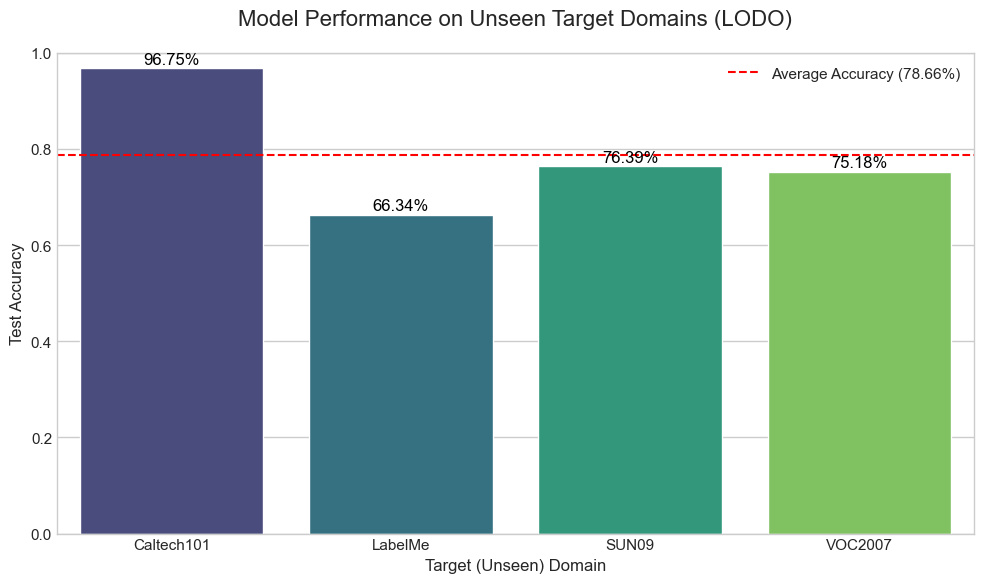


--- Dictionary for Final Plotting ---
# Copy the dictionary below and paste it into your final analysis notebook.
my_method_results = {
    'target_domain': ['Caltech101', 'LabelMe', 'SUN09', 'VOC2007'],
    'test_accuracy': [0.9675, 0.6634, 0.7639, 0.7518]
}

--- Experiment Complete ---


In [21]:
# =================================================================================
# SECTION 6: ANALYSIS & VISUALIZATION (with Dictionary Output)
# =================================================================================
# Now that all experiments are complete, we'll process the results
# and create visualizations to understand the performance of our method.
# ---------------------------------------------------------------------------------

# Add this magic command to ensure plots are displayed in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


# ---------------------------------------------------------------------------------
# 6.1: DISPLAY RESULTS IN A TABLE
# ---------------------------------------------------------------------------------
print("--- Final Experiment Results ---")

results_df = pd.DataFrame(experiment_results)
column_order = [
    "target_domain", "test_accuracy", "best_val_accuracy", "num_epochs",
    "batch_size", "learning_rate", "model_name"
]
existing_columns = [col for col in column_order if col in results_df.columns]
results_df = results_df[existing_columns]
average_accuracy = results_df['test_accuracy'].mean()

print(results_df.to_string())
print("\n" + "="*50)
print(f"Average Test Accuracy Across All Domains: {average_accuracy:.4f}")
print("="*50)


# ---------------------------------------------------------------------------------
# 6.2: VISUALIZE THE RESULTS
# ---------------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.barplot(
    data=results_df, x='target_domain', y='test_accuracy', ax=ax, palette='viridis'
)

for index, row in results_df.iterrows():
    ax.text(index, row['test_accuracy'] + 0.01, f"{row['test_accuracy']:.2%}",
            color='black', ha="center", fontsize=12)
    
ax.axhline(average_accuracy, ls='--', color='red', label=f'Average Accuracy ({average_accuracy:.2%})')

ax.set_title('Model Performance on Unseen Target Domains (LODO)', fontsize=16, pad=20)
ax.set_xlabel('Target (Unseen) Domain', fontsize=12)
ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_ylim(0, 1.0)
ax.legend()

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------
### NEW SECTION ###
# 6.3: GENERATE COPY-PASTE DICTIONARY FOR FINAL PLOTTING
# ---------------------------------------------------------------------------------
print("\n" + "="*70)
print("--- Dictionary for Final Plotting ---")
print("# Copy the dictionary below and paste it into your final analysis notebook.")

# Determine the variable name based on the notebook (you can adjust this)
# For the baseline notebook, you'd want 'baseline_results'.
# For the evolutionary notebook, you'd want 'evolutionary_results'.
method_name = "my_method_results" # Generic name
if "baseline" in os.getcwd(): # Simple check if 'baseline' is in the notebook path
    method_name = "baseline_results"
elif "drop-out" in os.getcwd():
    method_name = "evolutionary_results"
    
# Extract the lists from the DataFrame
domain_list = results_df['target_domain'].tolist()
accuracy_list = [round(acc, 4) for acc in results_df['test_accuracy'].tolist()]

# Print in the desired format
print(f"{method_name} = {{")
print(f"    'target_domain': {domain_list},")
print(f"    'test_accuracy': {accuracy_list}")
print(f"}}")
print("="*70)


print("\n--- Experiment Complete ---")

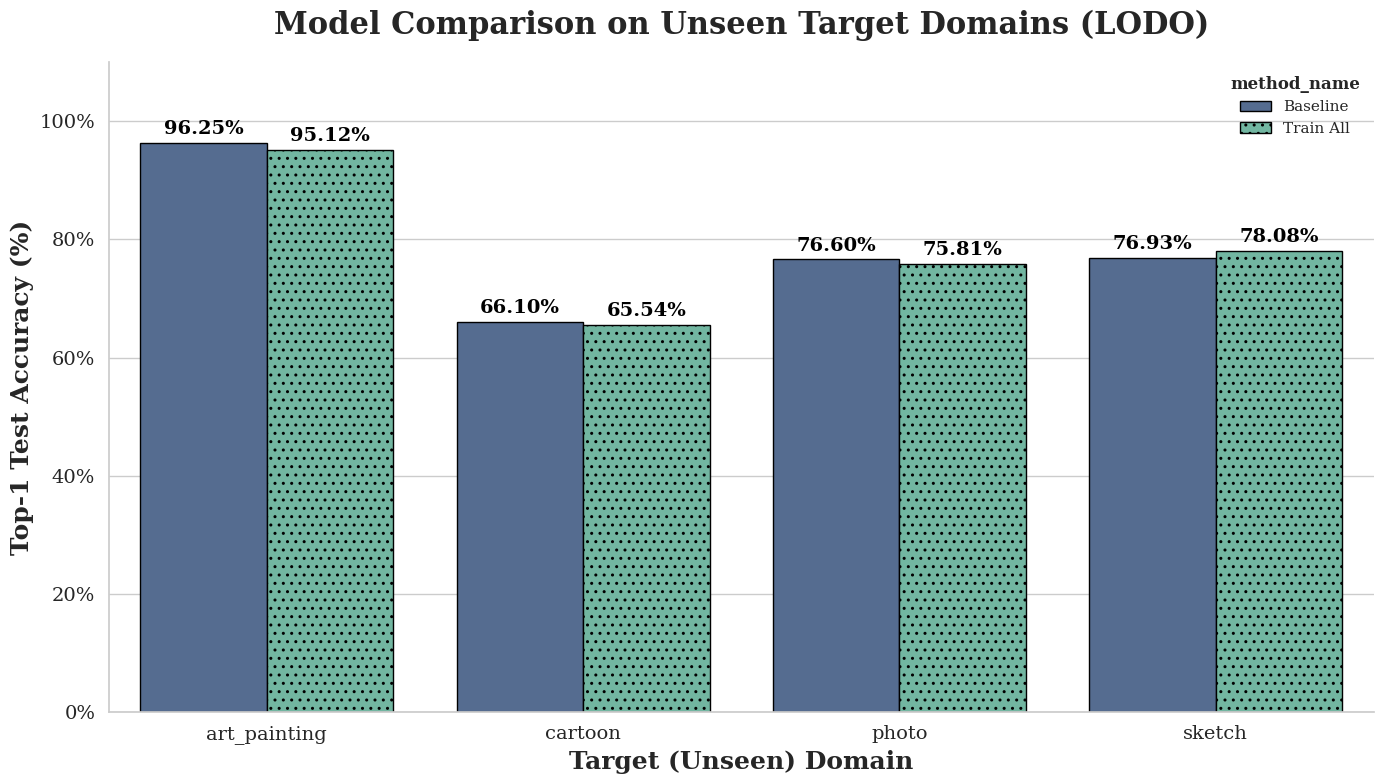


--- Average Performance Summary ---
Average Baseline Accuracy: 78.97%
Average Evolutionary Dropout Accuracy: 78.64%


In [22]:
# =================================================================================
# SECTION 7: COMPARATIVE ANALYSIS & VISUALIZATION (ACADEMIC STYLE - FINAL FIX)
# =================================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 7.1: COMBINE EXPERIMENT RESULTS ---
baseline_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.9625, 0.661, 0.766, 0.7693]
}
# Using the results from your successful Option 4 run
evolutionary_results = {
    'target_domain': ['art_painting', 'cartoon', 'photo', 'sketch'],
    'test_accuracy': [0.9512, 0.6554, 0.7581, 0.7808]
}
baseline_df = pd.DataFrame(baseline_results)
baseline_df['method_name'] = 'Baseline'
evolutionary_df = pd.DataFrame(evolutionary_results)
evolutionary_df['method_name'] = 'Train All'
combined_df = pd.concat([baseline_df, evolutionary_df])

# --- 7.2: CREATE THE GROUPED BAR CHART (ROBUST VERSION) ---

sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(14, 8))

custom_palette = {'Baseline': '#4B6A9A', 'Train All': '#66C2A5'}

barplot = sns.barplot(
    data=combined_df,
    x='target_domain',
    y='test_accuracy',
    hue='method_name',
    ax=ax,
    palette=custom_palette,
    edgecolor='black'
)

### THE FIX IS HERE ###
# Use the robust 'containers' method to apply patterns correctly.

# ax.containers[0] is the container for the first hue category (Baseline)
# ax.containers[1] is the container for the second hue category (Evolutionary Dropout)

# We want to add a pattern to the second container's bars.
for bar in ax.containers[1]:
    bar.set_hatch('..')

# We also need to apply the pattern to the corresponding legend handle.
# The legend handles are created in the same order.
ax.legend_.legend_handles[1].set_hatch('..')

# --- Add annotations (text on bars) ---
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            f"{p.get_height():.2%}",
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center',
            xytext=(0, 10),
            textcoords='offset points',
            fontsize=14,
            fontweight='bold',
            color='black'
        )

# --- Final plot styling ---
ax.set_title('Model Comparison on Unseen Target Domains (LODO)', fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Target (Unseen) Domain', fontsize=18, fontweight='bold')
ax.set_ylabel('Top-1 Test Accuracy (%)', fontsize=18, fontweight='bold')
ax.set_ylim(0, 1.1)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

legend = ax.get_legend()
plt.setp(legend.get_title(), fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

# --- Print the final summary table ---
avg_baseline = baseline_df['test_accuracy'].mean()
avg_evolutionary = evolutionary_df['test_accuracy'].mean()
print("\n--- Average Performance Summary ---")
print(f"Average Baseline Accuracy: {avg_baseline:.2%}")
print(f"Average Evolutionary Dropout Accuracy: {avg_evolutionary:.2%}")